# Overview

This week is all about working with data. I'm not going to lie to you. This part might be frustrating - but frustration is an integral part of learning. Real data is almost always messy & difficult ... and learning to deal with that fact, is a key part of being a data scientist. 


Enough about the process, let's get to the content. 

![Text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/DC_vs_marvel.png "Great image choice, Sune")

Today, we will use network science and Wikipedia to learn about the relationships of **[DC](https://en.wikipedia.org/wiki/Lists_of_DC_Comics_characters)** and **[Marvel](https://en.wikipedia.org/wiki/Lists_of_Marvel_Comics_characters)** characters. 

To create the network, we will download the Wikipedia pages for all characters in each of the DC and Marvel universes. Next, we ill create the network of the pages that link to each other. Since wikipedia pages link to each other. So [Spider-Man](https://en.wikipedia.org/wiki/Spider-Man) links to [Superman](https://en.wikipedia.org/wiki/Superman), for example (it really does, but most links are "within-universe").

Next time, we'll use our network skills (as well as new ones) to understand that network. Further down the line, we'll use natural language processing to understand the text displayed on those pages.

But for today, the tasks are

* Learn about regular expressions
* Learn about Pandas dataframes
* Download and store (for later use) all the character-pages from Wikipedia
* Extract all the internal wikipedia-links that connect the characters on wikipedia
* Generate the network of characters on wikipedia. 
* Calculate some simple network statistics.

## The informal intro (not to be missed)

Today I talk about 

* The COVID-19 situation
* Results of the user satisfaction questionnaire
* Assignment 1
* Today's exercises

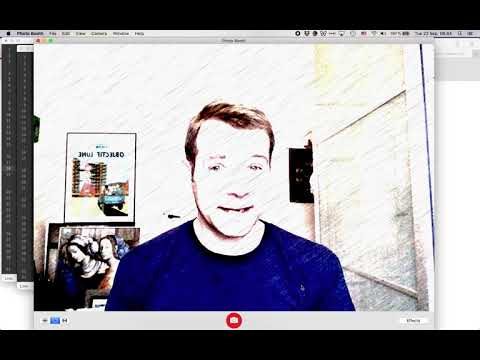

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("FCP8HgvzZKc",width=800, height=450)

---

# Prelude: Regular expressions

Before we get started, we have to get a little head start on the _Natural Language Processing_ part of the class. This is a new direction for us, up to now, we've mostly been doing math-y stuff with Python, but today, we're going to be using Python to work through a text. The central thing we need to be able to do today, is to extract internal wikipedia links. And for that we need regular expressions.

> _Exercises_: Regular expressions round 1\.
> 
> * Read [**this tutorial**](https://developers.google.com/edu/python/regular-expressions) to form an overview of regular expressions. This is important to understand the content of the tutorial (also very useful later), so you may actually want to work through the examples.
> * Now, explain in your own words: what are regular expressions?
> * Provide an example of a regex to match 4 digits numbers (by this, I mean precisely 4 digits, you should not match any part of numbers with e.g. 5 digits). In your notebook, use `findall` to show that your regex works on this [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt). **Hint**: a great place to test out regular expressions is: https://regex101.com.
> * Provide an example of a regex to match words starting with "super". Show that it works on the [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt).
> 

Finally, we need to figure out how how to match internal wiki links. Wiki links come in two flavors. They're always enclosed in double square brackets, e.g. `[[wiki-link]]` and can either occur like this:

    ... some text [[Aristotle]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/Aristotle`](https://en.wikipedia.org/wiki/Aristotle). 

The second flavor has two parts, so that links can handle spaces and other more fancy forms of references, here's an example:

    ... some text [[John_McCain|John McCain]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/John_McCain`](https://en.wikipedia.org/wiki/Eudemus_of_Rhodes). Now it's your turn.

> _Exercise_: Regular expressions round 2\. Show that you can extract the wiki-links from the [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt). Perhaps you can find inspiration on stack overflow or similar. **Hint**: Try to solve this exercise on your own (that's what you will get the most out of - learning wise), but if you get stuck ... you will find the solution in one of the video lectures below.
> 

In [1]:
import re
import requests
import pandas as pd
from concurrent import futures 
import networkx as nx
import collections
import matplotlib.pyplot as plt
import numpy as np
import random

**Answer**

* regular expressions is a tool for matching text patterns
* [0-9]{4}
* super[\w]*

In [2]:
test_url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt"
res = requests.get(test_url)

In [3]:
print(re.findall('[0-9]{4}', res.text))
print(re.findall('super[\w]*', res.text))

['1234', '9999', '2345']
['superpolaroid', 'supertaxidermy', 'superbeer']


In [31]:
pattern1 = '\[\[(.*?)\]\]'
for group in re.findall(pattern1, res.text):
    print(group)

drinking vinegar
gentrify
hashtag
Bicycle|Bicycle(two-wheeled type)
Pitchfork|Pitchfork Magazine


# Prelude part 2: Pandas DataFrames


Before starting, we will also learn a bit about [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), a very user-friendly data structure that you can use to manipulate tabular data. Pandas dataframes are implemented within the [pandas package] (https://pandas.pydata.org/).

Pandas dataframes should be intuitive to use. **We suggest you to go through the [10 minutes to Pandas tutorial](https://pandas.pydata.org/pandas-docs/version/0.22/10min.html#min) to learn what you need to solve the next exercise.**

---

# Part A: Download the Wikipedia pages of characters

It's time to download all of the pages of the characters. Use your experience with APIs from Week 1\. To get started, I **strongly** recommend that you re-watch the **APIs video lecture** from that week - it contains lots of useful tips on this specific activity (yes, I had planned this all along!). I've included it below for your covenience.

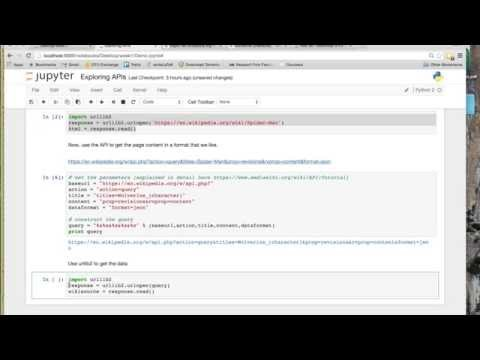

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo("9l5zOfh0CRo",width=800, height=450)

Now, back in the day, I had all students first download the names of all the characters, starting from 

* https://en.wikipedia.org/wiki/Lists_of_Marvel_Comics_characters
* https://en.wikipedia.org/wiki/Lists_of_DC_Comics_characters

But that resulted in so much pain and suffering that recently I've decided against that. Instead, you can download all the names, nice and clean, here (it might still include couple of *noisy* links, but should be fine in 95% of records):
 
* **[Marvel List](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/marvel_characters.csv)**
* **[DC List](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/dc_characters.csv)**

*The files contain names and corresponding wiki-link. If link if absent, then the character does not have a specific page and information about this particular character can be find in the [Marvel](https://en.wikipedia.org/wiki/Lists_of_Marvel_Comics_characters) or [DC](https://en.wikipedia.org/wiki/Lists_of_DC_Comics_characters) lists* **(BUT YOU DO NOT HAVE TO DO THAT - if you do not feel comfortable with extracting paragraphs from lists it is okay to ignore Comic characters with absent links)** .

> ### A challenge
> However, if you're feeling tough, you can head over to our [Hardcore List Parsing](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/Hardcore_List_Parsing.ipynb) notebook, full of tricks to help you try out creating these lists on your own! If you manage to do both Marvel and DC on our own, you will officially have graduated to brown-belt Python hacker. (Black belt challenges coming later in the year.)

In [5]:
dcUrl = '../files/dc_characters.csv'
marvelUrl = '../files/marvel_characters.csv'
dcNames = pd.read_csv(dcUrl, delimiter='|')
marvelNames = pd.read_csv(marvelUrl, delimiter='|')

In [6]:
def getContent(keyword):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + keyword
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    res = requests.get(query)
    return res.text

In [8]:
def downloadDc():
    path = './data/DC/'
    def task(name, link):
        page = getContent(link)
        with open(path + name, 'w') as f:
            f.write(page)
    with futures.ThreadPoolExecutor(max_workers=5) as executor:
        for index, row in dcNames.iterrows():
            if str(row[2]) != 'nan':
                future = executor.submit(task, row[1], str(row[2]))


def downloadMarvel():
    path = './data/Marvel/'
    def task(name, link):
        page = getContent(link)
        with open(path + name, 'w') as f:
            f.write(page)

    with futures.ThreadPoolExecutor(max_workers=5) as executor:
        for index, row in marvelNames.iterrows():
            if str(row[2]) != 'nan':
                future = executor.submit(task, row[1], str(row[2]))


In [11]:
downloadDc()

In [12]:
downloadMarvel()

---

# Part B: Building the networks

Now, we're going to build one huge NetworkX directed graph, which includes both DC and Marvel Characters. 

The nodes in the network will be all the characters, and we will place an edge between nodes $A$ and $B$ if the Wikipedia page of node $A$ links to the Wikipedia page of node $B$.

 

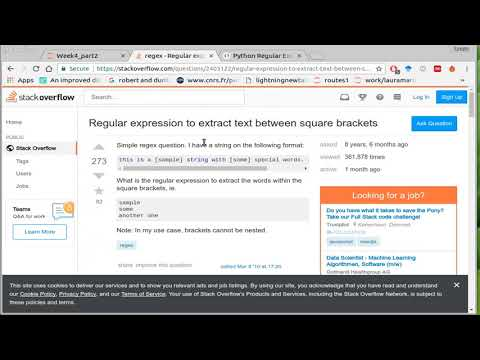

In [13]:
YouTubeVideo("9i_c31v9Nb0",width=800, height=450)


> 
> _Exercise_: Build the network of Comics Characters 

> Now we can build the network. Isn't this a little bit cool? What a dataset :)

> The overall strategy for this is the following: 
> Take the pages you have downloaded for each character. 
> Each page corresponds to a politician, which is a node in your network. 
> Find all the hyperlinks in a characters page that link to another node of the network (e.g. an other character). 
> There are many ways to do this, but below, I've tried to break it down into natural steps. 
> Keep in mind that the network should include **both** DC and Marvel characters (and that it is possible that some DC Characters will have links to Marvel Characters and vice-versa).
> 
> **Note**: When you add a node to the network, also include an `attribute` (i.e. that specifies the universe where the character comes from; either DC, or Marvel)
>
>
> * Use a regular expression to extract all outgoing links from each of the pages you downloaded above. 
> * For each link you extract, check if the target is a character. If yes, keep it. If no, discard it.
> * Use a NetworkX [`DiGraph`](https://networkx.github.io/documentation/development/reference/classes.digraph.html) to store the network. Store also the properties of the nodes (i.e. from which universe they hail).
> * When have you finished, you'll notice that some nodes do not have any out- or in- degrees. You may *discard* those from the network.


In [17]:
dcs = set(dcNames['CharacterName'])
marvels = set(marvelNames['CharacterName'])

In [32]:
DG = nx.DiGraph()

def getNeighbors(text):
    pattern = '\[\[(.*?)\]\]'
    rv = []
    for gp in re.findall(pattern, text):
        if gp in dcs or gp.split('|')[0] in dcs:
            rv.append((gp, 'DC'))
        elif gp in marvels or gp.split('|')[0] in marvels:
            rv.append((gp, 'Marvel'))
        
    return rv

for name in dcs:
    name = str(name)
    DG.add_node(name, universe="DC")
    try:
        with open('./data/DC/' + name, 'r') as f:
            text = f.read()
            neighbors = getNeighbors(text)
            for n in neighbors:
                DG.add_node(n[0], universe=n[1])
                DG.add_edge(name, n[0])
    except FileNotFoundError as e:
        pass

for name in marvels:
    name = str(name)
    DG.add_node(name, universe="Marvel")
    try:
        with open('./data/Marvel/' + name, 'r') as f:
            text = f.read()
            neighbors = getNeighbors(text)
            for n in neighbors:
                DG.add_node(n[0], universe=n[1])
                DG.add_edge(name, n[0])
    except FileNotFoundError as e:
        pass

In [34]:
rmNodes = []
for node in DG.nodes:
    if DG.degree(node) == 0:
        rmNodes.append(node)

for node in rmNodes:
    DG.remove_node(node)


> *Exercise*: Simple network statistics and analysis

> * What is the number of nodes in the network? 
> * More importantly, what is the number of links?
> * What is the number of links connecting Marvel and DC? What do those links mean?
> * Plot the in and out-degree distributions. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
>     * Compare the degree distribution to a *random network* with the same number of nodes and *p*
>     * Compare the degree distribution to a *scale-free* network with the same number of nodes.
> * Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected.
> * Who are the top 5 most connected Marvel characters (again in terms of both in/out-degree)?
> * Who are the top 5 most connected DC characters (again in terms of both in/out-degree)?

**Answer**


In [35]:
print("Number of nodes ", len(DG.nodes))
print("Number of links ", len(DG.edges))

Number of nodes  3185
Number of links  17343


In [36]:
DCMavelConCount = 0
for link in DG.edges:
    node1, node2 = link
    if DG.nodes[node1]['universe'] == 'DC' and DG.nodes[node2]['universe'] == 'Marvel':
        DCMavelConCount += 1
    elif DG.nodes[node2]['universe'] == 'DC' and DG.nodes[node1]['universe'] == 'Marvel':
        DCMavelConCount += 1

print("Links between DC and Marvel ", DCMavelConCount)

Links between DC and Marvel  925


Means the number of citation between Marvel and DC is 925

In [37]:
in_degree_sequence = sorted([d for n, d in DG.in_degree()], reverse=True)
out_degree_sequence = sorted([d for n, d in DG.out_degree()], reverse=True)

In [38]:
def plotDegree(degree_sequence, label=''):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.plot(x, y, 'o', label=label)

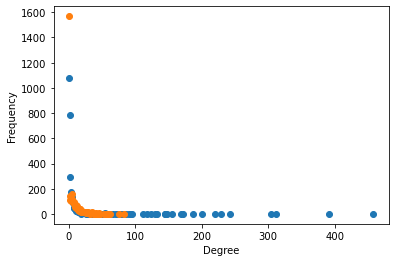

In [39]:
plotDegree(in_degree_sequence, label='in_degree')
plotDegree(out_degree_sequence, label='out_degree')

Compare to the in_degree, most of the out_degree are gathering in low degree area which means that most of the pages are more frequently being cited than cite other pages

## Degree comparison

In [40]:
degree_sequence = sorted([d for n, d in DG.degree()], reverse=True)

def logPlot(degree_sequence):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.title('Degree Distribution(Log-Log)')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.loglog(x, y, 'o')


def histPlot(degree_sequence):
    vec = [i for i in range(min(degree_sequence), max(degree_sequence) + 1)]
    hx, hy, _ = plt.hist(degree_sequence, bins=vec)
    plt.bar(hy[:-1], hx)
    plt.title('Histogram of the degree distribution')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    

### Charactors degree plot

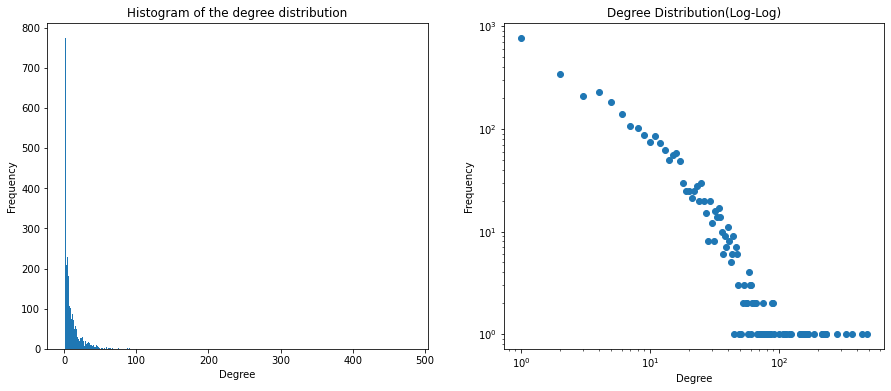

In [41]:
f = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
histPlot(degree_sequence)
plt.subplot(1,2,2)
logPlot(degree_sequence)
plt.show()

### random network degree plot¶

In [44]:
N = len(DG.nodes)
k = sum(degree_sequence) / N
p = k / (N - 1)

randomG = nx.generators.random_graphs.erdos_renyi_graph(N, p)
random_degree_sequence = sorted([d for n, d in randomG.degree()], reverse=True)

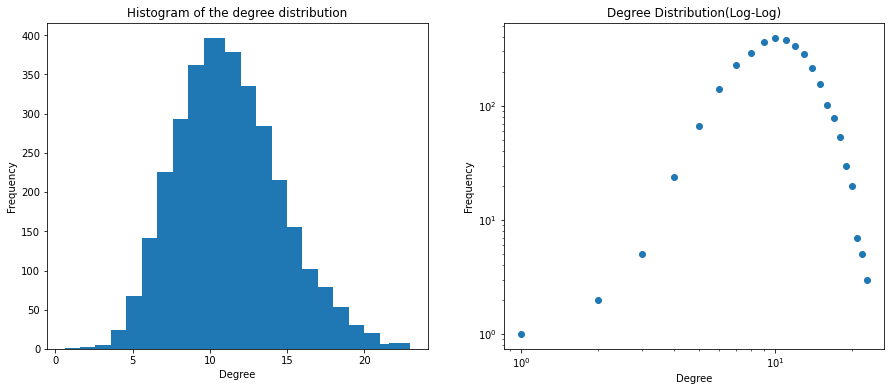

In [45]:
f = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
histPlot(random_degree_sequence)
plt.subplot(1,2,2)
logPlot(random_degree_sequence)
plt.show()

### scale-free network degree plot

In [46]:
def buildScaleFreeNetWork(N):
    g = nx.Graph()
    g.add_edges_from([(1, 2)])

    def getNodeByDegree(g):
        edges = list(g.edges)
        tmp = []
        for item in edges:
            tmp.append(item[0])
            tmp.append(item[1])
        return random.choice(tmp)

    for i in range(3, N + 1):
        node = getNodeByDegree(g)
        g.add_edge(i, node)
    return g

sfG = buildScaleFreeNetWork(N)
sf_degree_sequence = sorted([d for n, d in sfG.degree()], reverse=True)

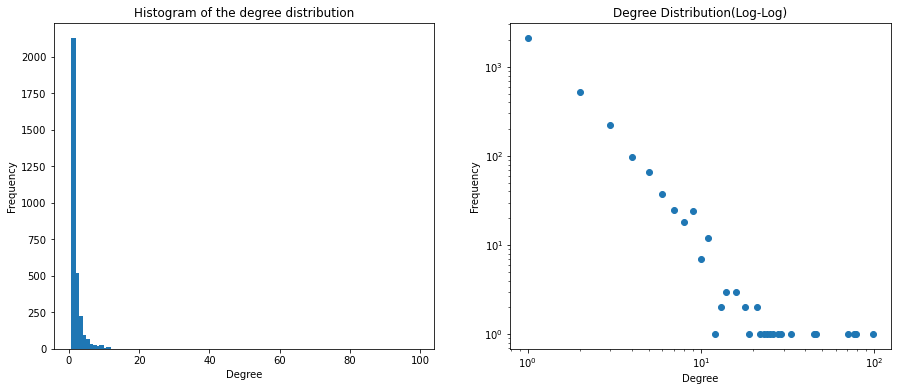

In [47]:
f = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
histPlot(sf_degree_sequence)
plt.subplot(1,2,2)
logPlot(sf_degree_sequence)
plt.show()

From the plot, we can see that the charactor network are more like a Scale-free network rather than a random network

> The total degree distribution (in + out degree) for you network should resemble the distribution displayed on the image below *(`Isolated` means that we have discarded the nodes with zero degrees)*:
![img](https://github.com/SocialComplexityLab/socialgraphs2020/blob/master/files/week4_degrees.png?raw=true)
> *Tip:* If you want your `matplotlib` plots to look *fancy*, you can download the `seaborn` package and do the following: `import seaborn as sns
sns.set()`


Big thanks to TA Germans for helping design these exercises.

## Top5 connected characters

In [54]:
in_degree_nodes = [(n, d) for n, d in DG.in_degree()]
in_degree_nodes = sorted(in_degree_nodes, key=lambda x: x[1], reverse=True)
out_degree_nodes = [(n, d) for n, d in DG.out_degree()]
out_degree_nodes = sorted(out_degree_nodes, key=lambda x: x[1], reverse=True)

In [55]:
print("Top 5 based on in_degree ", ','.join([item[0] for item in in_degree_nodes[:5]]))
print("Top 5 based on out_degree ", ','.join([item[0] for item in out_degree_nodes[:5]]))

Top 5 based on in_degree  Spider-Man,Captain America,Iron Man,Hulk,Batman
Top 5 based on out_degree  Jackal,Beast,Belthera, Queen,Brainiac 13,Venom


From the results we can see that the top 5 charactors based on in_degree are those pretty famous like superman, batman which make sence, since they are famous so they have a higher chance to be mentioned. On the other hand, the top 5 charactors based on out_degree are not quite famous. For me this reason could be that they require more explanation on the page to make people understand who they are. 

## Top5 connected Marvel characters

In [56]:
marvel_in_degree_nodes = [item for item in in_degree_nodes if DG.nodes[item[0]]['universe'] == 'Marvel']
marvel_out_degree_nodes = [item for item in out_degree_nodes if DG.nodes[item[0]]['universe'] == 'Marvel']

In [57]:
print("Top 5 based on in_degree ", ','.join([item[0] for item in marvel_in_degree_nodes[:5]]))
print("Top 5 based on out_degree ", ','.join([item[0] for item in marvel_out_degree_nodes[:5]]))

Top 5 based on in_degree  Spider-Man,Captain America,Iron Man,Hulk,Doctor Strange
Top 5 based on out_degree  Beast,Venom,Iron Man,Captain America,She-Hulk


   ## Top5 connected DC characters

In [58]:
dc_in_degree_nodes = [item for item in in_degree_nodes if DG.nodes[item[0]]['universe'] == 'DC']
dc_out_degree_nodes = [item for item in out_degree_nodes if DG.nodes[item[0]]['universe'] == 'DC']

In [59]:
print("Top 5 based on in_degree ", ','.join([item[0] for item in dc_in_degree_nodes[:5]]))
print("Top 5 based on out_degree ", ','.join([item[0] for item in dc_out_degree_nodes[:5]]))

Top 5 based on in_degree  Batman,Superman,Dorling Kindersley,Wonder Woman,Lex Luthor
Top 5 based on out_degree  Jackal,Belthera, Queen,Brainiac 13,Butcher,Quincy Sharp
